# LangChain: Q&A over Documents

An example might be a tool that would allow you to query a product catalog for items of interest.

In [2]:
#!pip install --upgrade langchain
#!pip install --upgrade langchain langchain-core langchain-openai pydantic
#!pip uninstall -y langchain langchain-core langchain-openai langchain-community langchain-classic
#!pip install -U langchain langchain-core langchain-openai langchain-community
#!pip install langchain-classic

In [3]:
import os
from openai import OpenAI
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import CSVLoader
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_classic.chains.retrieval import create_retrieval_chain
from langchain_classic.chains.combine_documents import create_stuff_documents_chain
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Read API key from text file
with open(r"D:\desktop\Pankaj_New_OpenAI_Key.txt", "r") as file:
    os.environ["OPENAI_API_KEY"] = file.read().strip()


# Step 1 Load  the document

In [6]:
file = r"D:\desktop\Lang_Chain\OutdoorClothingCatalog_fixed.csv"

loader = CSVLoader(file_path=file,encoding="utf-8")
docs = loader.load()
print(docs[0])

page_content='content: [Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 0}),' metadata={'source': 'D:\\desktop\\Lang_Chain\\OutdoorClothingCatalog_fixed.csv', 'row': 0}


In [7]:
print(type(docs))
print(docs[0].page_content[:350])


<class 'list'>
content: [Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size.


In [8]:
print(docs[0].metadata.items())

dict_items([('source', 'D:\\desktop\\Lang_Chain\\OutdoorClothingCatalog_fixed.csv'), ('row', 0)])


In [9]:
print(len(docs))


1000


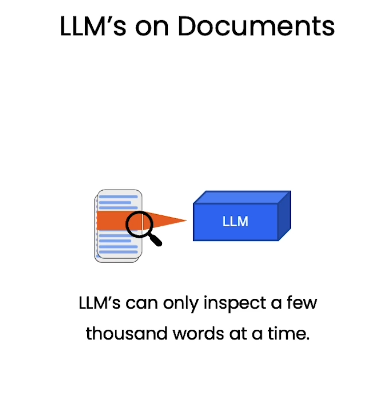

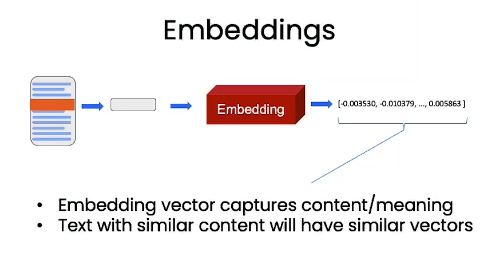
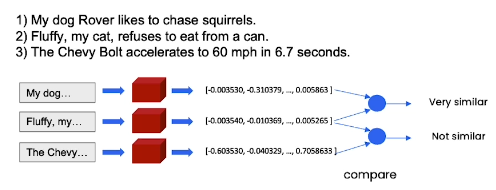

In [12]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

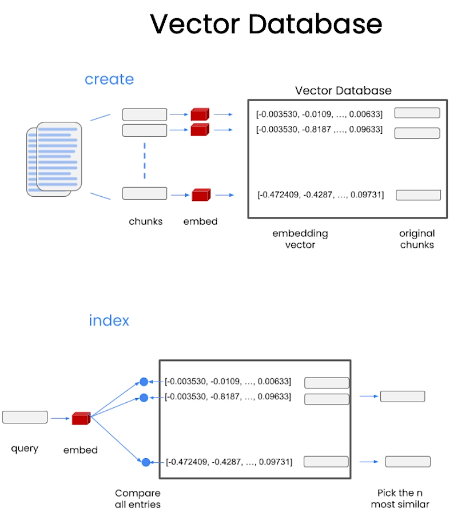

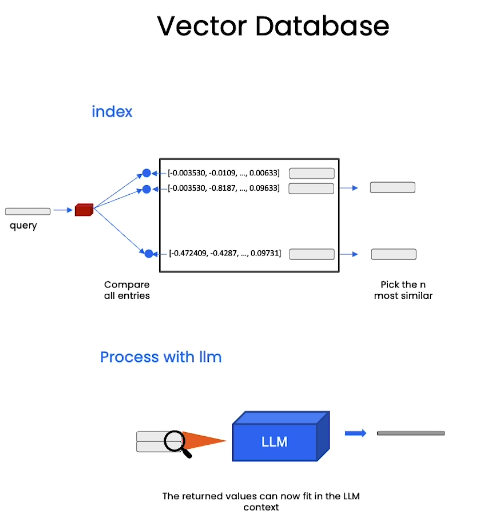

## A chunk is a small piece of a document created so LLMs can embed, search, and reason over large data efficiently.

| Aspect         | Chunking                       | Tokenization                     |
| -------------- | ------------------------------ | -------------------------------- |
| What it splits | Documents into text blocks     | Text into tokens                 |
| Level          | High-level (paragraph/section) | Low-level (subword units)        |
| Purpose        | Retrieval & context management | Model computation                |
| Used in        | RAG, vector DB, indexing       | Every LLM call                   |
| Human readable | Yes                            | No                               |
| Controlled by  | chunk_size, overlap            | tokenizer (BPE, WordPiece, e

- Chunking = dividing the book into chapters or pages

- Tokenization = breaking each sentence into letters/words for reading

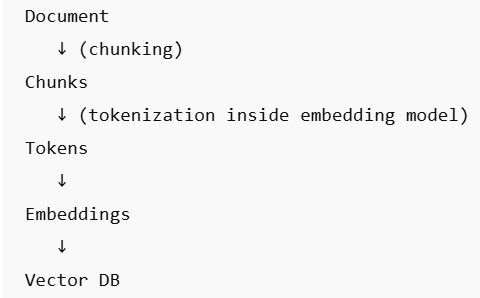

ctor DB
tc.) |


- When a user asks a question:

- Query → tokenized → embedding → retrieve chunks → chunks tokenized again → LLM 


In [17]:
#pip install docarray

# Step 2 Create Embeddings

In [19]:
from langchain_openai import ChatOpenAI,OpenAIEmbeddings

In [20]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
# create an embedding model
# This model converts text into a numerical vector.

In [21]:
# Example of Embedding
embed = embeddings.embed_query("Hi my name is Harrison")
# This returns a list of floating-point numbers (vector)
# Each sentence is represented as a 1536-dimensional vector.

In [22]:
print(len(embed))
# This tells you the dimension of the embedding vector.

1536


In [23]:
print(embed[:10])
# Just to inspect what the vector looks like
# Embedding dimension is fixed by the model architecture, not by the length of the text.
# 1 chunk → 1 vector (1536-dim)

[0.0057072690688073635, -0.005853141658008099, -0.06277387589216232, 0.02265889011323452, -0.05134718492627144, -0.023886652663350105, -0.004716550000011921, 0.035787433385849, -0.03612780198454857, -0.060731660574674606]


# Step 3 Create vector database

In [25]:
vectorstore = DocArrayInMemorySearch.from_documents(docs,embeddings)

In [26]:
# Example 
query = "Please suggest a shirt with sunblocking"

In [27]:
docs = vectorstore.similarity_search(query, k =2)
# by default k = 4

### Similarity Search:
The query is converted into an embedding vector and compared with all stored document embeddings.
The top-k most similar document chunks are returned as Document objects.

In [29]:
len(docs)

2

LangChain does:

1️⃣ Convert your query into an embedding vector
2️⃣ Compare it with all stored document embeddings
3️⃣ Find the top-4 most similar vectors (cosine similarity)
4️⃣ Return them as Document objects

In [31]:
print(docs[0])

page_content='content: Document(page_content=': 255\nname: Sun Shield Shirt by\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \n\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\n\nFabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.\n\nAdditional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.\n\nSun Protection That Won\'t Wear Off\nOur high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun\'s harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.', metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 255}),' metadata={'source': 'D:\\desktop\\Lang_Chain\\OutdoorClothingCatalog_fixed.csv', 'row': 255}


In [32]:
for i, doc in enumerate(docs):
    print(f"\nResult {i+1}:")
    print(doc.page_content[:300])



Result 1:
content: Document(page_content=': 255\nname: Sun Shield Shirt by\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \n\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\n\nFabric & Care: 78% nylon, 22% Lycra Xtr

Result 2:
content: Document(page_content=": 374\nname: Men's Plaid Tropic Shirt, Short-Sleeve\ndescription: Our Ultracomfortable sun protection is rated to UPF 50+, helping you stay cool and dry. Originally designed for fishing, this lightest hot-weather shirt offers UPF 50+ coverage and is great for extended


In [33]:
list(docs)

[Document(metadata={'source': 'D:\\desktop\\Lang_Chain\\OutdoorClothingCatalog_fixed.csv', 'row': 255}, page_content='content: Document(page_content=\': 255\\nname: Sun Shield Shirt by\\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \\n\\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\\n\\nFabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.\\n\\nAdditional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.\\n\\nSun Protection That Won\\\'t Wear Off\\nOur high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun\\\'s harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.\', metadata={\'source\': \'OutdoorClothingCatalog_1000.csv\', \'row\':

# Step 4 Create retriever

In [35]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# Step 5 Create LLM

In [37]:
llm = ChatOpenAI(temperature=0,model='gpt-3.5-turbo')


# Step 6 Define a prompt with context placeholder
- Define a prompt template that has a {context} placeholder, and let the retrieval chain automatically fill it.

- **What is Context in RAG?**
- Context is the set of relevant document chunks retrieved from the vector database based on the user query.
- Only this limited context is sent to the LLM, not the full dataset.
This improves accuracy and avoids token limit errors.

In [39]:
# from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_template("""
You are given product data below.

Task:
- Identify only SHIRTS with sun protection (UPF, SunSmart, UV).
- Create a markdown table with columns:
| Name | Sun Protection Summary |

Rules:
- Use only the context
- Do not hallucinate products
- If none found, say "No matching products found"

Context:{context}

Question: {input}""")


# Step 7: Create a “stuff documents” chain

In [41]:
# from langchain_classic.chains.combine_documents import create_stuff_documents_chain
combine_chain = create_stuff_documents_chain(llm, prompt)

# Step 8: Create the retrieval chain

In [43]:
retrieval_chain = create_retrieval_chain(retriever, combine_chain)

# Step 9: Ask Question

In [45]:
query ="Please list all your shirts with sun protection \
in a table in markdown and summarize each one."

In [46]:
response = retrieval_chain.invoke({"input": query})

display(Markdown(response["answer"]))

| Name | Sun Protection Summary |
| --- | --- |
| Sun Shield Shirt | UPF 50+ rated sun protection fabric recommended by The Skin Cancer Foundation, blocks 98% of harmful UV rays |
| Men's Plaid Tropic Shirt, Short-Sleeve | UPF 50+ sun protection, SunSmart technology blocks 98% of UV rays, wrinkle-free fabric |
| Men's Tropical Plaid Short-Sleeve Shirt | UPF 50+ sun protection fabric, blocks 98% of harmful UV rays |
| Women's Tropical Tee, Sleeveless | SunSmart™ UPF 50+ rated fabric, blocks 98% of harmful UV rays, wrinkle-resistant |
| Sunrise Tee | Built-in SunSmart™ UPF 50+ rated fabric, blocks harmful UV rays, lightweight and quick-drying |

In [47]:
query2 = "Which products are suitable for hot weather activities?"
display(Markdown(retrieval_chain.invoke({"input": query2})["answer"]))

| Name | Sun Protection Summary |
| --- | --- |
| Men's Plaid Tropic Shirt, Short-Sleeve | UPF 50+ sun protection, SunSmart technology blocks 98% of UV rays |

- **Documents → Retriever → Context → Prompt → LLM → Final Answer**
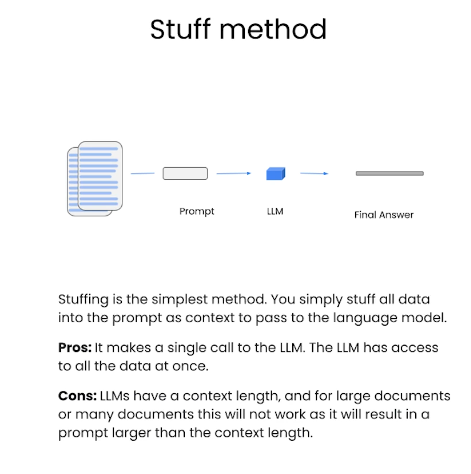


![image.png](attachment:9bc49f57-d323-4b8c-85b5-a9b554a9a50f.png

)
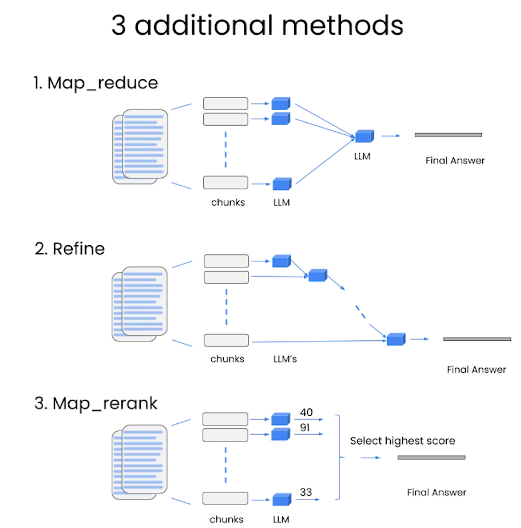

LangChain now uses:

Retriever → Prompt → LLM → create_retrieval_chain

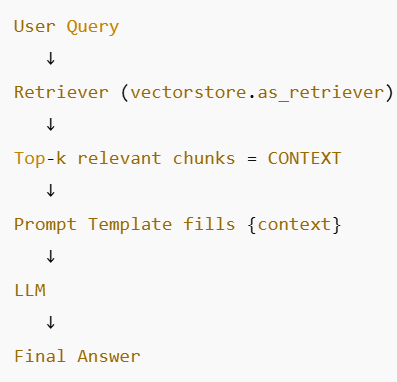

### Key Takeaways
1. Documents are split into chunks and embedded.
2. Retriever selects only relevant chunks.
3. LLM answers using retrieved context (RAG).
4. Never send the entire dataset directly to the LLM.
5. Prompt design controls output format (markdown table).


In [52]:
def ask_question(query):
    response = retrieval_chain.invoke({"input": query})
    return response["answer"]

display(Markdown(ask_question("Please suggest a shirt with sunblocking")))


| Name | Sun Protection Summary |
| --- | --- |
| Sun Shield Shirt | UPF 50+ rated – the highest rated sun protection possible. |
| Men's Plaid Tropic Shirt, Short-Sleeve | UPF 50+ coverage, SunSmart technology blocks 98% of the sun's harmful UV rays. |
| Men's Tropical Plaid Short-Sleeve Shirt | SPF 50+ sun protection, blocking 98% of the sun's harmful rays. |
| Tropical Breeze Shirt | UPF 50+ rated – the highest rated sun protection possible. |
| Men's TropicVibe Shirt, Short-Sleeve | SPF 50+ sun protection, blocking 98% of the sun's harmful rays. |